# アニーリングを用いたクラスタリング

このチュートリアルでは、アニーリングの応用の一例としてPyQUBOとOpenjijを利用したクラスタリングを取り上げます。  

## クラスタリング

クラスタリングとは与えられたデータを$n$個のクラスターに分けるというタスクです($n$は外部から与えられているとします)。簡単のため、今回はクラスター数が2を考えましょう。

### クラスタリングのハミルトニアン
今回は、以下のハミルトニアンを最小化することでクラスタリングを行います。

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j} (1 - \sigma _i \sigma_j)
$$

$i, j$はサンプルの番号、$d_{i,j}$は２つのサンプル間の距離、$\sigma_i=\{-1,1\}$は２つのクラスターのどちらかに属しているかを表すスピン変数です。  
このハミルトニアンの和の各項は   

- $\sigma_i  = \sigma_j $のとき、0
- $\sigma_i  \neq \sigma_j $のとき、$d_{i,j}$  

となります。右辺のマイナスに注意すると、ハミルトニアン全体では「異なるクラスに属しているサンプル同士の距離を最大にする$\{\sigma _1, \sigma _2 \ldots \}$の組を選びなさい」という問題に帰着することがわかります。


### 必要なライブラリのインポート

In [ ]:
!pip install jijmodeling-transpiler

In [2]:
# ライブラリのインポート
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix

import openjij as oj
import jijmodeling as jm
from jijmodeling.transpiler.pyqubo.to_pyqubo import to_pyqubo

###  JijModelingとOpenJijを用いたクラスタリング

最初に、JijModelingを用いた上記のハミルトニアンを定式化します。JijModelingでは、スピン変数$\sigma_i$を扱えないので、バイナリ変数$x_i$で書けるように、$\sigma_i = 2x_i - 1$という関係を用いて書き直します。

In [3]:
problem = jm.Problem("clustering")
d = jm.Placeholder("d", dim=2)
N = d.shape[0].set_latex('N')
x = jm.Binary("x", shape=(N))
i = jm.Element("i", (0, N))
j = jm.Element("j", (0, N))
problem += (
    -1 / 2 * jm.Sum([i, j], d[i, j] * (1 - (2 * x[i] - 1) * (2 * x[j] - 1)))
)
problem

### 人工データの生成

今回は人工的に二次元平面上の明らかに線形分離可能なデータを生成しましょう。

In [4]:
data = []
label = []
for i in range(100):
    # [0, 1]の乱数を生成
    p = np.random.uniform(0, 1)
    # ある条件を満たすときをクラス1、満たさないときを-1
    cls =1 if p>0.5 else -1
    # ある座標を中心とする正規分布に従う乱数を作成
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
# DataFrameとして整形
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

/home/kohei/Project/OpenJij/.venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='x', ylabel='y'>

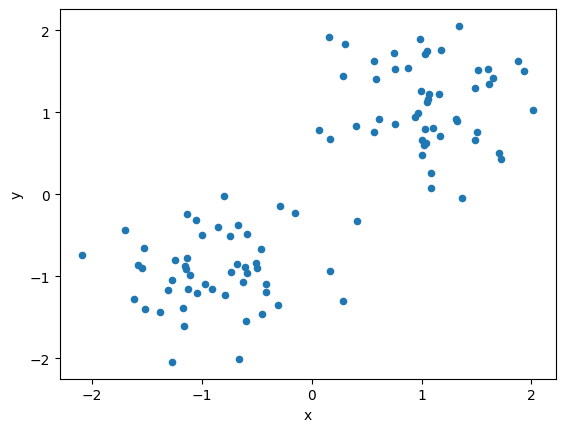

In [5]:
# データセットの可視化
df1.plot(kind='scatter', x="x", y="y")

In [6]:
instance_data = {'d':distance_matrix(df1, df1)}

## OpenJijを使ってクラスタリング問題を解く
数理モデルとデータができたので、早速、Openjijを使って問題を解いていきましょう。

In [7]:
pyq_obj, pyq_cache = to_pyqubo(problem, instance_data, {})
qubo, constant = pyq_obj.compile().to_qubo()
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)
result = pyq_cache.decode(response)

可視化をしてみましょう。

Text(0, 0.5, 'y')

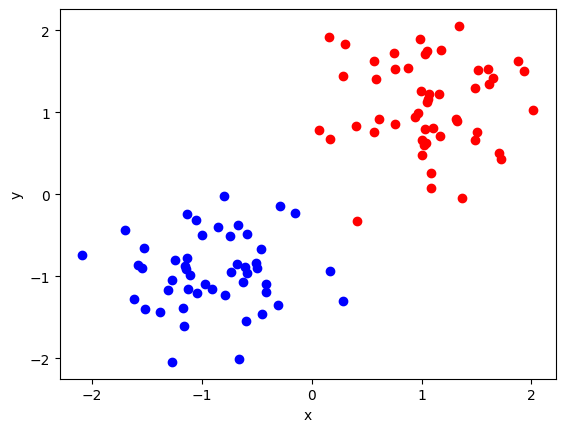

In [8]:
for idx in range(0, len(instance_data['d'])):
    if idx in result.record.solution["x"][0][0][0]:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")
plt.xlabel('x')
plt.ylabel('y')

赤と青のクラスに分類できていることがわかります。